# Quantifying Accuracy/Precision of Model Parameter Values

> **Note**
>
> Download the example file here: [HP3_TE300_SPC630.hdf5](https://zenodo.org/record/5902313/files/HP3_TE300_SPC630.hdf5)

First, let's run the following code to generate a basic analysis for us to begin working with.
This code is essential the same as that found in the [tutorial](#Tutorial).

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import fretbursts as frb
import burstH2MM as bhm

filename = 'HP3_TE300_SPC630.hdf5'
# load the data into the data object frbdata
frbdata = frb.loader.photon_hdf5(filename)
# if the alternation period is correct, apply data
# plot the alternation histogram
# frb.bpl.plot_alternation_hist(frbdata) # commented so not displayed in notebook
frb.loader.alex_apply_period(frbdata)
# calcualte the background rate
frbdata.calc_bg(frb.bg.exp_fit, F_bg=1.7)
# plot bg parameters, to verify quality
# frb.dplot(frbdata, frb.hist_bg) # commented so not displayed in notebook
# now perform burst search
frbdata.burst_search(m=10, F=6)
# make sure to set the appropriate thresholds of ALL size
# parameters to the particulars of your experiment
frbdata_sel = frbdata.select_bursts(frb.select_bursts.size, th1=50)
# make BurstData object to get data into bursth2MM
bdata = bhm.BurstData(frbdata_sel)
# calculate models
bdata.models.calc_models()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7.1).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------
# Total photons (after ALEX selection):    11,414,157
#  D  photons in D+A excitation periods:    5,208,392
#  A  photons in D+A excitation periods:    6,205,765
# D+A photons in  D  excitation period:     6,611,308
# D+A photons in  A  excitation period:     4,802,849

 - Calculating BG rates ... get bg th arrays
Channel 0
[DONE]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction

The model converged after 1 iterations

The model converged after 36 iterations

The model converged after 128 iterations

The model converged after 404 iterations

2

So it looks like the 4 state model is the ideal model, so we will use it going forward

<a id='bootstrap'></a>
# Bootstrap method

Perhaps the easiest to understand method for quantifying uncertainty in a model is the bootstrap method.
In this method, the bursts are split up into $N$ subsets, and separate optimizations are run on each subset.
Then the variance of each parameter value across the $N$ different subsets serves as a quantification of the uncertainty.

In burstH2MM, the `H2MM_result` object has the `bootstrap_eval()` method which performs this operation.

`bootstram_eval()` has one keyword argument: `subsets` by which you can specify the number of subsets to divide the data into. 
The default is 10, which is usually a good compromise.

In [2]:
bdata.models[2].bootstrap_eval(subsets=5)

The model converged after 284 iterations

The model converged after 222 iterations

The model converged after 2035 iterations

The model converged after 230 iterations

The model converged after 275 iterations

(array([[89.31507039, 60.39327794, 51.39792885],
        [32.52743518, 36.89794537, 24.65784844],
        [ 8.20597788, 16.43889435, 12.39366764]]),
 array([0.02551389, 0.00435776, 0.00127755]),
 array([0.00960336, 0.00264026, 0.00212474]))

Note how the number of subsets is the number of optimizations. This method automatically stores the results in the `H2MM_result.bootstrap_err` attribute, and the transition rate, E, and S values are also supplied as return values.

Once you run bootstrap_eval, you can now access `trans_std_bs`, `E_std_bs`, `S_std_bs` attributes of `H2MM_result`, which are the standard deviations of each parameter of the optimized models of the subsets.

In [3]:
bdata.models[2].trans_std_bs

array([[89.31507039, 60.39327794, 51.39792885],
       [32.52743518, 36.89794537, 24.65784844],
       [ 8.20597788, 16.43889435, 12.39366764]])

In [4]:
bdata.models[2].E_std_bs, bdata.models[2].S_std_bs

(array([0.02551389, 0.00435776, 0.00127755]),
 array([0.00960336, 0.00264026, 0.00212474]))

### Closer examination of models

`H2MM_result.boostrap_err` attribute allows closer examination of these subsets.
This attribute is an instance of the class `ModelError.Bootstrap_Error`, which is made to coordinate the bootstrap evaluation.
The `H2MM_result` attributes `H2MM_result.trans_std_bs`, `H2MM_result.E_std_bs`, `H2MM_result.S_std_bs` are just aliases of the attributes of `ModelError.Bootstrap_Error.trans_std`, `ModelError.Bootstrap_Error.E_std`, and `ModelError.Bootstrap_Error.S_std` in its `H2MM_result.bootstrap_err` attribute.

In [5]:
bdata.models[2].bootstrap_err.trans_std

array([[89.31507039, 60.39327794, 51.39792885],
       [32.52743518, 36.89794537, 24.65784844],
       [ 8.20597788, 16.43889435, 12.39366764]])

In [6]:
bdata.models[2].bootstrap_err.E_std, bdata.models[2].bootstrap_err.S_std

(array([0.02551389, 0.00435776, 0.00127755]),
 array([0.00960336, 0.00264026, 0.00212474]))

For E and S, the leakage/direct excitation/$\gamma$ and $\beta$ correct values: `ModelError.Boostrap_Error.E_std_corr`, and `ModelError.Boostrap_Error.S_std_corr`

In [7]:
bdata.models[2].bootstrap_err.E_std_corr, bdata.models[2].bootstrap_err.S_std_corr

(array([0.02551389, 0.00435776, 0.00127755]),
 array([0.00960336, 0.00264026, 0.00212474]))

If on the other hand, you would prefer to take the standard error, instead of standard deviation of the subsets, there are equivalent attributes `ModelError.Boostrap_Error.trans_err`, `ModelError.Boostrap_Error.E_err`, and `ModelError.Boostrap_Error.S_err`. 

In [8]:
bdata.models[2].bootstrap_err.trans_err

array([[39.94291376, 27.00869497, 22.98585256],
       [14.54671124, 16.50126282, 11.02732506],
       [ 3.66982487,  7.35169705,  5.54261666]])

In [9]:
bdata.models[2].bootstrap_err.E_err, bdata.models[2].bootstrap_err.S_err

(array([0.01141016, 0.00194885, 0.00057134]),
 array([0.00429475, 0.00118076, 0.00095021]))

For E and S, the leakage/direct excitation/$\gamma$ and $\beta$ correct values: `ModelError.Boostrap_Error.E_err_corr`, and `ModelError.Boostrap_Error.S_err_corr`

In [10]:
bdata.models[2].bootstrap_err.E_err_corr, bdata.models[2].bootstrap_err.S_err_corr

(array([0.01141016, 0.00194885, 0.00057134]),
 array([0.00429475, 0.00118076, 0.00095021]))

You can also see the values of the individual subset models.
This is done through the attribute `ModelError.Bootstrap_Error.models`.


This attribute is again another special class, `ModelError.ModelSet` used for organizing models that vary only in their specific parameter values, but share the same number of states, and data and divisor scheme.
It lets you access the transition rate, E and S values as attributes, and for E and S, access these with the `ModelError.ModelSet.trans`, `ModelError.ModelSet.E`, `ModelError.ModelSet.S` attributes respectively. For E and S, the leakage/direct excitation/$\gamma$ and $\beta$ correct values are accessible with the `ModelError.ModelSet.E_corr` and `ModelError.ModelSet.S_corr` attributes.

The organization of these arrays is `[state, subset]` for E and S, and `[from_state, to_state, subset]` for transition rates. 

In [11]:
bdata.models[2].bootstrap_err.models.trans

array([[[1.99993025e+07, 5.47412479e+02, 1.50107233e+02],
        [2.56911279e+02, 1.99996697e+07, 7.33962982e+01],
        [2.71843192e+01, 9.25544845e+01, 1.99998803e+07]],

       [[1.99994454e+07, 5.01289484e+02, 5.33487918e+01],
        [2.02533276e+02, 1.99996915e+07, 1.06001447e+02],
        [7.16687668e+00, 1.38306798e+02, 1.99998545e+07]],

       [[1.99994312e+07, 5.68807994e+02, 2.00516546e-05],
        [2.15768390e+02, 1.99996411e+07, 1.43089272e+02],
        [4.79837333e+00, 1.25242149e+02, 1.99998700e+07]],

       [[1.99995343e+07, 4.36097878e+02, 2.95649436e+01],
        [1.55146896e+02, 1.99997508e+07, 9.40438423e+01],
        [7.29033218e+00, 1.10009161e+02, 1.99998827e+07]],

       [[1.99993033e+07, 6.12696740e+02, 8.40202867e+01],
        [2.11897792e+02, 1.99997083e+07, 7.98317553e+01],
        [8.19460327e+00, 1.01374391e+02, 1.99998904e+07]]])

In [12]:
bdata.models[2].bootstrap_err.models.E, bdata.models[2].bootstrap_err.models.S

(array([[0.63874835, 0.16143699, 0.06563951],
        [0.66284055, 0.15296922, 0.06698833],
        [0.67054299, 0.15811327, 0.06875795],
        [0.62598317, 0.16620047, 0.06867949],
        [0.69909412, 0.15815618, 0.06616314]]),
 array([[0.43073863, 0.55001657, 0.97045621],
        [0.43598782, 0.55806883, 0.97225223],
        [0.43725447, 0.55429823, 0.9687245 ],
        [0.43685134, 0.55273276, 0.96839454],
        [0.41192581, 0.55269972, 0.97400269]]))

In [13]:
bdata.models[2].bootstrap_err.models.E_corr, bdata.models[2].bootstrap_err.models.S_corr

(array([[0.63874835, 0.16143699, 0.06563951],
        [0.66284055, 0.15296922, 0.06698833],
        [0.67054299, 0.15811327, 0.06875795],
        [0.62598317, 0.16620047, 0.06867949],
        [0.69909412, 0.15815618, 0.06616314]]),
 array([[0.43073863, 0.55001657, 0.97045621],
        [0.43598782, 0.55806883, 0.97225223],
        [0.43725447, 0.55429823, 0.9687245 ],
        [0.43685134, 0.55273276, 0.96839454],
        [0.41192581, 0.55269972, 0.97400269]]))

## Loglikelihood Uncertainty Evaluation

The bootstrap error is very simple, however, it also can take a long time, and the particular subsets used may have a significant influence on the calculated values.

### What is loglikelihood uncertainty?

The assessment of the loglikelihood uncertainties relies on finding the loglikelihood of models where one of the model parameter values has been offset from the optimal value.
While a full statistical analysis would require integration across the whole parameter space, we note that the loglikelihoods generally distribute in a Gaussian-like manner, and therefore we can approximate the uncertainty by finding the point at which the loglikelihood is some amount less than the optimal model:

$ LL(\lambda _{\Delta E_{n}}) = LL(\lambda _{optimal}) - 0.5$

There are two points at which this is true, one where $E_{n}$ is greater than the optimal $E_{n}$, and another, where $E_{n}$ is less than the optimal $E_{n}$, denoted $E_{n, high}$ and $E_{n, low}$ respectively. 

The errors reported are thus:

$err_{LL}(E) = \frac{E_{n,high} - E_{n,low}}{2}$

Note that in most cases, $E_{n, high} - E_{n, optimal} \approx E_{n, optimal} - E_{n, low}$

This is not true however, for transition rates, and thus, in lieu of reporting an average value to represent a +/- type of error, instead we report directly the high and low transition rates.


### Calculating loglikelihood uncertainty

Estimation of Loglikelihood uncertainty is handled by `ModelError.Loglik_Error` objects, which are created automatically when a `H2MM_result` object is created, and stored in the `H2MM_result.loglik_err` attribute.
Upon its creation, no values are actually calculated, only the skeleton exists.

All parameter times (E/S/transition rates) follow the same basic rules, so we will start by demonstrating uncertainty estimation for E.

To estimate the uncertainty for E, we use the `ModelError.Loglik_Error.get_E_err()` method.

In [14]:
E_err = bdata.models[2].loglik_err.get_E_err(0)
E_err

0.005624999999999991

The equivalent for the stoichiometry is `ModelError.Loglik_Error.get_S_err()`:

In [15]:
S_err = bdata.models[2].loglik_err.get_S_err(2)
S_err

0.00077636718749996

These value indicate the point at which models where a given parameter value is varied from the optimal, have a loglikelihood 0.5 less than the optimal model, ie:

$ LL(\lambda _{\Delta E_{n}}) = LL(\lambda _{optimal}) - 0.5$

There are two points at which this is true, one where $E_{n}$ is greater than the optimal $E_{n}$, and another, where $E_{n}$ is less than the optimal $E_{n}$, denoted $E_{n, high}$ and $E_{n, low}$ respectively. 

The errors reported are thus:

$err_{LL}(E) = \frac{E_{n,high} - E_{n,low}}{2}$

Note that in most cases, $E_{n, high} - E_{n, optimal} \approx E_{n, optimal} - E_{n, low}$

This is not true however, for transition rates, and thus, in lieu of reporting an average value to represent a +/- type of error, instead we report directly the high and low transition rates.

In [16]:
trans_err = bdata.models[2].loglik_err.get_trans_err(0,1)
trans_err

masked_array(data=[501.85880590306624, 562.3571669228369],
             mask=[False, False],
       fill_value=inf)

The `ModelError.Loglik_Error.get_E/S_err()` methods also allow passing the keyword parameter `simple` as `simple=False` to return the low/high values like `ModelError.Loglik_Error.get_trans_err()`

In [17]:
E_err = bdata.models[2].loglik_err.get_E_err(0, simple=False)
E_err

masked_array(data=[0.6546853599116281, 0.6659353599116281],
             mask=[False, False],
       fill_value=nan)

In [18]:
S_err = bdata.models[2].loglik_err.get_S_err(0, simple=False)
S_err

masked_array(data=[0.4273356364488786, 0.43415204269887864],
             mask=[False, False],
       fill_value=nan)

## Accessing Values Previously Calculated

Calculations of the uncertainty values are stored in masked arrays, so that only calculated values are available.
These can be accessed through the attributes `ModelError.Loglik_Error.E`, `ModelError.Loglik_Error.S`, `ModelError.Loglik_Error.trans`.

In [19]:
bdata.models[2].loglik_err.trans

masked_array(
  data=[[[--, --],
         [501.85880590306624, 562.3571669228369],
         [--, --]],

        [[--, --],
         [--, --],
         [--, --]],

        [[--, --],
         [--, --],
         [--, --]]],
  mask=[[[ True,  True],
         [False, False],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True]]],
  fill_value=inf)

In [20]:
bdata.models[2].loglik_err.E

masked_array(data=[0.005624999999999991, --, --],
             mask=[False,  True,  True],
       fill_value=nan)

In [21]:
bdata.models[2].loglik_err.S

masked_array(data=[0.003408203125000009, --, 0.00077636718749996],
             mask=[False,  True, False],
       fill_value=nan)

The `ModelError.Loglik_Error.E` and `ModelError.Loglik_Error.S` are a little more processed than the `ModelError.Loglik_Error.trans`, as these do not show the low/high directly for a given state, but rather show half the difference between them.


If you want to see the actual low and high values, these can be accessed with the `ModelError.Loglik_Error.E_lh` and `ModelError.Loglik_Error.S_lh` attributes (this is basically the same as passing the `simple=False` keyword argument to `ModelError.Loglik_Error.get_E/S_err()`):

In [22]:
bdata.models[2].loglik_err.E_lh

masked_array(
  data=[[0.6546853599116281, 0.6659353599116281],
        [--, --],
        [--, --]],
  mask=[[False, False],
        [ True,  True],
        [ True,  True]],
  fill_value=nan)

In [23]:
bdata.models[2].loglik_err.S_lh

masked_array(
  data=[[0.4273356364488786, 0.43415204269887864],
        [--, --],
        [0.9700226579124809, 0.9715753922874808]],
  mask=[[False, False],
        [ True,  True],
        [False, False]],
  fill_value=nan)

Concluding this list of access attributes, the loglikelihood values of these models are also stored in the `ModelError.Loglik_Error.E_ll`, `ModelError.Loglik_Error.S_ll`, and `ModelError.Loglik_Error.trans_ll`attributes:

In [24]:
bdata.models[2].loglik_err.E_ll

masked_array(
  data=[[-133208.37002081453, -133208.37125588214],
        [--, --],
        [--, --]],
  mask=[[False, False],
        [ True,  True],
        [ True,  True]],
  fill_value=-inf)

In [25]:
bdata.models[2].loglik_err.S_ll

masked_array(
  data=[[-133208.36515007343, -133208.36806724552],
        [--, --],
        [-133208.36725677078, -133208.36851899838]],
  mask=[[False, False],
        [ True,  True],
        [False, False]],
  fill_value=-inf)

### Adjusting thresholds

From the earlier equation, the estimated error is defined by having a loglikelihood $0.5$ less than the optimal, however, if you wish to change this threshold, to say $1.0$, this can be done (before running any `get_` method) by setting the `ModelError.Loglik_Error.thresh` attribute:

In [26]:
bdata.models[2].loglik_err.thresh = 1.0
S_err = bdata.models[2].loglik_err.get_S_err(1)
S_err

0.00277343749999992

Another factor that can be adjusted is how precisely the search algorithm needs to find the loglikelihood, this factor is stored in the `ModelError.Loglik_Error.flex` attribute. The default is $0.005$

In [27]:
bdata.models[2].loglik_err.flex = 5e-2
E_err = bdata.models[2].loglik_err.get_E_err(1)
E_err

0.002695312500000005

These set univeral threshold/flex values, is generally preferred, these values can be altered for each calculation.
This works by passing `thresh` and `flex` keyword arguments to the `get_E/S/trans_err()`.

> **Warning**
>
> Passing `thresh` and `flex` keyword arguments to the `get_E/S/trans_err()` will only affect the current calculation.
> Therefore all other calculations will have different `thresh` and `flex` values, and therefore will not be comparable to one another.
> This is why it is discouraged to use this method.

In [28]:
E_err = bdata.models[3].loglik_err.get_E_err(2, thresh=0.1, flex=1e-2)
E_err

0.0010156249999999922

### Clearing Values

Since values already stored are not recalculated, if a new threshold is set, previous values can be cleared using the `ModelError.Loglik_Error.clear_E` `ModelError.Loglik_Error.clear_S()`, and `ModelError.Loglik_Error.clear_trans()`, and `ModelError.Loglik_Error.clear_all()` methods.
These reset their respective arrays:

In [29]:
bdata.models[2].loglik_err.clear_E()
bdata.models[2].loglik_err.clear_S()
bdata.models[2].loglik_err.clear_trans()

As the name suggests, `ModelError.Loglik_Error.clear_all()` clears all the values.
So the three lines above, together do what is done bellow in a single line:

In [30]:
bdata.models[2].loglik_err.clear_all()

## Calculating All Uncertainty Values

When a given `H2MM_result` has only a few states, it will not take long to characterize the uncertainty of all model parameters, but for 5+ states, this becomes time consuming.
Hence the choice to break with burstH2MM's normal strategy of calculating on demand and storing the result, and instead using a `get_E/S/trans` strategy, and masked arrays, that unmask values that have been calculated.

However, if you so desire, the `ModelError.Loglik_Err.all_eval()` method provides a shortcut, and evaluates all parameters for you.
This is great for 2 and 3 state models, workable for 4 state models, and less advisable for 5+ state models.

In [31]:
# reset thresh and flex to default before re-calculating everything
bdata.models[2].loglik_err.thresh, bdata.models[2].loglik_err.flex = 0.5, 5e-3

# evaluate all parameters
bdata.models[2].loglik_err.all_eval()
bdata.models[2].loglik_err.trans

masked_array(
  data=[[[--, --],
         [501.85880590306624, 562.3571669228369],
         [40.92595696233021, 67.31424834785025]],

        [[193.2941908421583, 217.69955433877504],
         [--, --],
         [95.3687750943463, 111.56819133190652]],

        [[3.735882210708622, 12.601354449681962],
         [108.29230392786711, 124.56154227875899],
         [--, --]]],
  mask=[[[ True,  True],
         [False, False],
         [False, False]],

        [[False, False],
         [ True,  True],
         [False, False]],

        [[False, False],
         [False, False],
         [ True,  True]]],
  fill_value=inf)

In [32]:
bdata.models[2].loglik_err.E

masked_array(data=[0.005624999999999991, 0.0019238281250000128,
                   0.0010351562499999883],
             mask=[False, False, False],
       fill_value=nan)

In [33]:
bdata.models[2].loglik_err.S

masked_array(data=[0.003408203125000009, 0.001953125, 0.00077636718749996],
             mask=[False, False, False],
       fill_value=-inf)

## Examining Loglikelihood Variance Along a Given Parameter

So far uncertainty estimation has been built finding how far a given parameter must be varied to alter the loglikelihood by a certain value.
This is done by an iterative process, and each iteration is saved.
The parameter values and loglikelihoods are stored in attributes of `ModelError.Loglik_Error`.

| Parameter type | Parameter Value                      | Loglikelihood                      |
| :------------- | :----------------------------------- | :--------------------------------- |
| E              | `ModelError.Loglik_Error.E_rng`      | `ModelError.Loglik_Error.E_ll_rng` |
| S              | `ModelError.Loglik_Error.S_rng`      | `ModelError.Loglik_Error.S_ll_rng` |
| Trans          | `ModelError.Loglik_Error.t_rate_rng` | `ModelError.Loglik_Error.t_ll_rng` |


These are 2D (for trans) and 1D (for E/S) numpy object arrays, whose elements are 1D numpy arrays of all values/loglikelihoods evaluates thus far.

These arrays however will often have values clustered around where the search value is, whereas for more in-depth analysis, it would be more convenient to have an evenly spaced set of values.
Such arrays can be generated by the `ModelError.Loglik_Error.E_space()`, `ModelError.Loglik_Error.S_space()`, and`ModelError.Loglik_Error.trans_space()` methods.

The only required argument to these functions is the state or transition for which to calculate the array.
The `rng` and `steps` keyword arguments let you specify the range over which to space the parameter values, and the number of values to evaluate (think of this as similar to the numpy linspace and logspace functions).

`steps` is always a positive integer.

`rng` however has several options:

| Option    | Behavior | When callable | `steps` ignored |
| :-------- | :------- | :------------ | :-------------- |
| int/float | multiply value by difference between low/high value and optimal value to offset for low/high values of range | Must have evaluated uncertainty before calling | No |
| 2 element array-like (tuple, list, numpy array) | low/high values for the range | Call anytime | No |
| Many element array-like | The individual values of the specified parameter to evaluate the matrix, steps ignored | Call anytime | Yes |

> **Note**
>
> If `rng` is not specified, it behaves like `rng=2` and therefore prior to evaluating, you must have already performed `ModelError.Loglik_Error.get_E/S/trans_err()` for the given state or transition.

In [34]:
Erng, Ell = bdata.models[2].loglik_err.E_space(0)
Erng[0], Erng[-1], Erng.size

(0.6490603599116281, 0.6715603599116281, 20)

In [35]:
Srng, Sll = bdata.models[2].loglik_err.S_space(1, rng=3, steps=10)
Srng[0], Srng[-1], Srng.size

(0.5476305043692009, 0.5593492543692009, 10)

> **Note**
>
> For `ModelError.Loglik_Error.trans_space()` the transition must be specified as a 2-tuple of (from_state, to_state).

In [36]:
trng, tll = bdata.models[2].loglik_err.trans_space((0,1), rng=(100, 400))
trng[0], trng[-1], trng.shape

(99.99999999999999, 400.0, (20,))

The return values of these `ModelError.Loglik_Error.E/S/trans_space()` methods are automatically added to the `ModelError.Loglik_Error.E/S/t_rate_rng` and `ModelError.Loglik_Error.E/S/t_ll_rng` attributes, and so we can access all previously calculated values.
Note that these are stored in arrays of arrays, so you must specify the state/(from_state, to_state) that you want to access.

In [37]:
bdata.models[2].loglik_err.t_ll_rng[0,1]

array([-133421.33099232, -133408.78806882, -133396.23640999,
       -133383.70003837, -133371.20575538, -133358.78339051,
       -133346.46606703, -133334.29048486, -133322.29722086,
       -133310.53104671, -133299.04126446, -133287.88205962,
       -133277.11287135, -133266.79877898, -133257.01090396,
       -133247.82682552, -133239.33100829, -133231.61523905,
       -133224.77906936, -133218.93026009, -133209.34821107,
       -133208.70964879, -133208.45556987, -133208.39896862,
       -133208.37171389, -133208.34515839, -133208.24595844,
       -133207.99849658, -133208.16408984, -133208.27247109,
       -133208.33312831, -133208.36508243, -133208.3981236 ])

## Plotting Parameters

It is also possible to plot how the loglikelihood varies along a given parameter.

This uses the `ll_E_scatter()`, `ll_S_scatter()` and `ll_trans_scatter()` functions.
These functions take as required arguments a `H2MM_result` or `ModelError.Loglik_Error` object, and which state to plot. For `ll_E_scatter()` and `ll_S_scatter`, this is a single integer, indicating the index of the state. For `ll_trans_scatter()` this is two arguments: `from_state` and `to_state`.

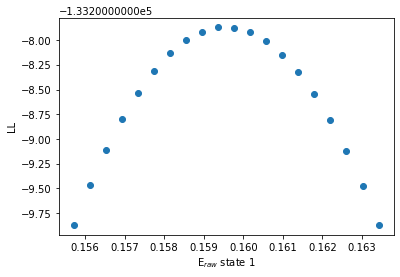

In [38]:
bhm.ll_E_scatter(bdata.models[2],1)

By default the `ll_E_scatter()` plots only an evenly spaced distribution of parameter values, it does this by calling `ModelError.Loglik_Error.E_space()` and plots only those values. You can pass the `rng` and `steps` keyword arguments to `ll_E_scatter()`, and these will be passed to `ModelError.Loglik_Error.E_space()`, to adjust the values plotted.

If on the other hand, you would like to see all values that have been evaluated, you can pass the keyword argument: `rng_only=False`, and it will plot all the values for the given parameter (everything stored in `ModelError.Loglik_Error.E_rng`)

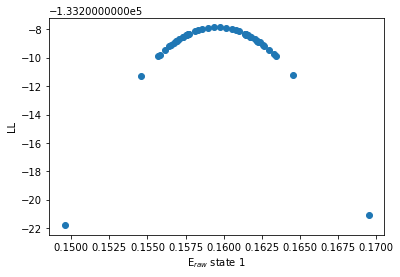

In [39]:
bhm.ll_E_scatter(bdata.models[2],1, rng_only=False)

Now let's see the same for the stoichiometry, same rules apply:

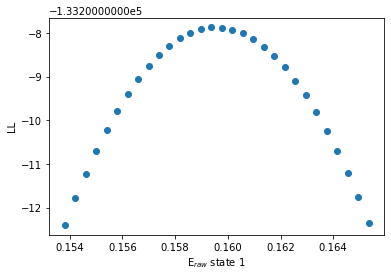

In [40]:
bhm.ll_E_scatter(bdata.models[2],1, rng=3, steps=30)

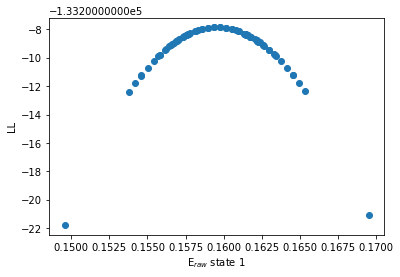

In [41]:
bhm.ll_E_scatter(bdata.models[2],1, rng=3, steps=30, rng_only=False)

And for transition rates, note that `ll_trans_scatter()` needs two indices for `from_state` and `to_state`, instead of just one.

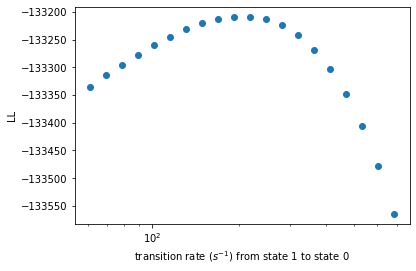

In [42]:
bhm.ll_trans_scatter(bdata.models[2], 1,0)

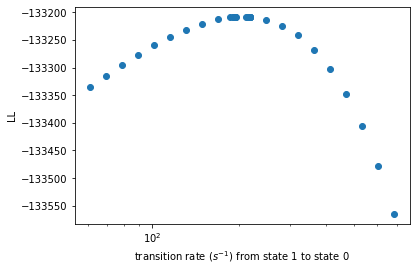

In [43]:
bhm.ll_trans_scatter(bdata.models[2], 1,0, rng=1.5, rng_only=False)

## Forcing Recalculation

The `ModelError.Loglik_Error.get_E/S/trans_err()` methods check if a value has been calculated, and can return such values without repeating the calculation.
There are however lower level methods that calculate values regardless of whether they were calculated before, and over-write the value if it was.
These are the `ModelError.Loglik_Error.E_eval()`, `ModelError.Loglik_Error.S_eval()`, and `ModelError.Loglik_Error.trans_eval()` methods.

> **Note**
>
> Unlike the `ModelError.Loglik_Error.get_E/S/trans_err()` methods, these methods do not have a return value, they just write their value to the corresponding array in the `ModelError.Loglik_Error` object.

If these methods are called with no keyword arguments, then all values of E, S, or trans will be calculated, but if only specific values are to be calculated, you can specify the `locs` keyword argument.
The `locs` keyword argument **must** be an iterable object where the elements are the desired states or transitions.

These methods also accept the same `thresh` and `flex` keyword arguments, and come with the same warnings of setting them individually instead of globally as for `ModelError.Loglik_Error.get_E/S/trans_err()`.
Also present is the `max_iter` keyword argument which specifies how many iterations of the search algorithm to execute seeking a loglikelihood close to`thresh` less than the optimal, within a range of `flex`.
Finally, for `ModelError.Loglik_Error.E/S_eval()`, there is the `step` keyword argument, and for `ModelError.Loglik_Error.trans_eval()` there is the `factor` argument, which specify the offset from the optimal value to use as an initial value in the search algorithm.

In [44]:
# clear previously stored values so re-evaluation can be tested
bdata.models[2].loglik_err.clear_all()

bdata.models[2].loglik_err.E_eval(locs=(0,1))
bdata.models[2].loglik_err.E

masked_array(data=[0.005624999999999991, 0.0019238281250000128, --],
             mask=[False, False,  True],
       fill_value=nan)

In [45]:
bdata.models[2].loglik_err.S_eval(locs=(0,1))
bdata.models[2].loglik_err.S

masked_array(data=[0.003408203125000009, 0.001953125, --],
             mask=[False, False,  True],
       fill_value=-inf)

In [46]:
bdata.models[2].loglik_err.trans_eval(locs=((0,1), (1,0),))
bdata.models[2].loglik_err.trans[:,:,0]

masked_array(
  data=[[--, 501.85880590306624, --],
        [193.2941908421583, --, --],
        [--, --, --]],
  mask=[[ True, False,  True],
        [False,  True,  True],
        [ True,  True,  True]],
  fill_value=inf)

## Covariant optimizations

In the previous characterization of uncertainty, only a single parameter value could be varied at a time.
Ideally we could make an N-dimensional grid of all combinations of parameter varied around their optimal values, but the shear number of points on such an N-dimensional grid grows so quickly with more states that such a method is not implemented here.

Instead, we can take one parameter at a time, fix it's value to various offsets from the optimal, and find the optimal values for all other parameters.
Thus we can see how changing one parameter affects the others, and how closely correlated they are to one another.

This is done through the covariance methods: `ModelError.Loglik_Error.covar_trans()`, `ModelError.Loglik_Error.covar_E()` and `ModelError.Loglik_Error.covar_S()`.
Similar to the `ModelError.Loglik_Error.trans/E/S_space` functions for the basic loglikelihood error, these functions take the particular transition/state you would like to evaluate as arguments, and also take the same `rng` and `steps` keyword arguments.

> **Note**
>
> Since these are optimization based parameters, these functions also take `max_iter` and `converged_min` keyword arguments to control when optimization terminates.

Once finished, the results are stored in the corresponding index of `ModelError.Loglik_Error.trans_covar`, `ModelError.Loglik_Error.E_covar`, and `ModelError.Loglik_Error.S_covar`, each of which is a numpy masked array of `ModelError.ModelSet` objects, so the calculated values will be stored in the corresponding index.
As with the `ModelError.Bootstrap_Error.models` attribute that was a `ModelError.ModelSet` object, access to the individual optimized parameters is provided through the appropriately named attributes.

In [47]:
bdata.models[2].loglik_err.covar_E(0)
bdata.models[2].loglik_err.E_covar[0].E[:,1]

The model converged after 82 iterations

The model converged after 78 iterations

The model converged after 74 iterations

The model converged after 68 iterations

The model converged after 53 iterations

The model converged after 54 iterations

The model converged after 69 iterations

The model converged after 75 iterations

The model converged after 79 iterations

The model converged after 84 iterations

array([0.15892296, 0.15906223, 0.15920173, 0.15934148, 0.15948151,
       0.15962176, 0.15976239, 0.15990334, 0.16004464, 0.16018629])

In [48]:
bdata.models[2].loglik_err.covar_S(1)
bdata.models[2].loglik_err.S_covar[1].S[:,0]

The model converged after 53 iterations

The model converged after 51 iterations

The model converged after 47 iterations

The model converged after 43 iterations

The model converged after 34 iterations

The model converged after 34 iterations

The model converged after 44 iterations

The model converged after 49 iterations

The model converged after 56 iterations

The model converged after 59 iterations

array([0.43215553, 0.43183874, 0.43152246, 0.43120671, 0.43089146,
       0.4305768 , 0.43026259, 0.42994891, 0.42963573, 0.42932306])

In [49]:
bdata.models[2].loglik_err.covar_trans(0,1)
bdata.models[2].loglik_err.trans_covar[0,1].trans[:,0,1]

The model converged after 76 iterations

The model converged after 78 iterations

The model converged after 80 iterations

The model converged after 83 iterations

The model converged after 80 iterations

The model converged after 92 iterations

The model converged after 136 iterations

The model converged after 209 iterations

Optimization reached maximum number of iterations

Optimization reached maximum number of iterations

array([ 158.70168905,  207.5797375 ,  271.51158681,  355.13361109,
        464.51012722,  607.57318246,  794.6977911 , 1039.45433638,
       1359.59270244, 1778.329506  ])

### Plotting Covariance

There are 3 functions for plotting the results of covariance: `covar_trans_ll_scatter()`, `covar_E_ll_scatter()` and `covar_S_ll_scatter()`.
These plot the loglikelihood of the optimized models against the value of the fixed parameter, they take two arguments: the  `ModelError.Loglik_Error` data, and the state to plot, or in the case of `covar_ll_trans_scatter()`, the particular transition, and thus 3 arguments are required, the `ModelError.Loglik_Error` data, `from_state` and `to_state`:

> **Note**
>
> This function is smart, and will take either the base `H2MM_result` or `ModelError.Loglik_Error`, if the former, it will automatically extract the `ModelError.Loglik_Error` object from the `H2MM_result.loglik_err` attribute. 

> **Note**
>
> If you have not already run `ModelError.Loglik_Error.covar_trans()`/`ModelError.Loglik_Error.covar_E()`/`ModelError.Loglik_Error.covar_S()` for the given state/transition, these functions will automatically run these with default parameters.

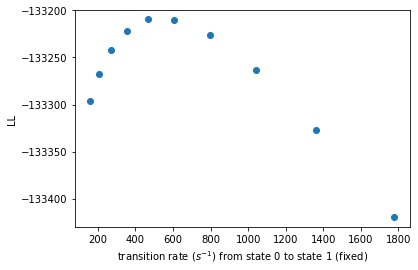

In [50]:
bhm.covar_trans_ll_scatter(bdata.models[2].loglik_err, 0,1)

These functions all also take the standard `ax` keyword argument, and all additional keyword arguments are passed to `ax.scatter()`

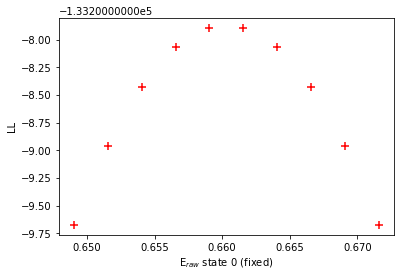

In [51]:
fig, ax = plt.subplots()
bhm.covar_E_ll_scatter(bdata.models[2], 0, ax=ax, s=60, marker='+', c='r')

Now there are a lot more values to plot, for instance, it is nice to see how when one parameter is offset, how does that affect the optimal values of other parameters.
There are no built-in plotting functions for this, since specifying which parameter makes the function signatures rather long and awkward, so such plots are left to the user.
Thankfully, if you know which particular combination of parameters you want to plot, it is not very difficult to setup your custom plots.

This will also be a good way to teach how to access these different values.

So say we want to see how, when the FRET efficiency of state 0 is varied, how does that affect the transitions from state 0 to state 1?

To do this we need to extract these parameters, and then plot them.

For demonstration purposes, we'll do this in 3 steps

1. Isolate the covariance results (`ModelError.ModelSet` object) of state 0.
2. Extract the (fixed) E values of state 0, and the (optimized) transition values from state 0 to state 1
3. Plot covariance

Text(0, 0.5, '0->1 $s^{-1}$, (optimized)')

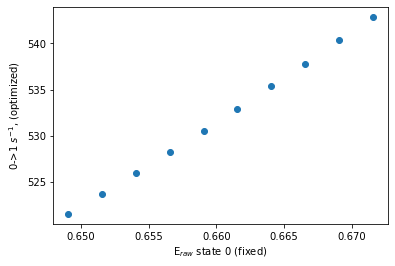

In [52]:
# get the ModelSet of state 0 E_covar
covar_E_state0 = bdata.models[2].loglik_err.E_covar[0]

# get fixed E values for x and optimized 
# note: we use ':' for the 0th dimension, so we look at each model
# then specify the state/transition of interest
x = covar_E_state0.E[:,0]
y = covar_E_state0.trans[:,0,1]

# plot
plt.scatter(x,y)

plt.xlabel("E$_{raw}$ state 0 (fixed)")
plt.ylabel(r"0->1 $s^{-1}$, (optimized)")

Of course, we could just do this all in one line (plus axis labels):

Text(0, 0.5, '0->1 $s^{-1}$, (optimized)')

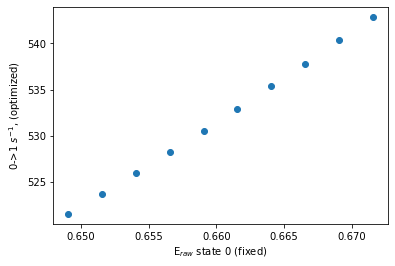

In [53]:
plt.scatter(bdata.models[2].loglik_err.E_covar[0].E[:,0], bdata.models[2].loglik_err.E_covar[0].trans[:,0,1])
plt.xlabel("E$_{raw}$ state 0 (fixed)")
plt.ylabel(r"0->1 $s^{-1}$, (optimized)")

Of course, there is no need to restrict ourselves to having the x axis be the fixed parameter, we can see how they all vary with one another, and maybe we'll give the fixed parameter as a color argument:

Text(0, 0.5, 'E$_{raw}$ state 2 (optimized)')

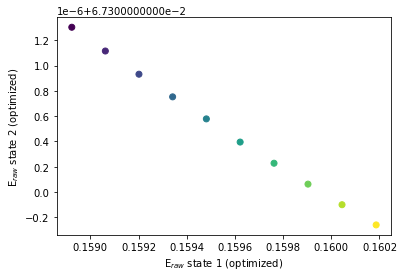

In [54]:
x = bdata.models[2].loglik_err.E_covar[0].E[:,1] # state 1 E values
y = bdata.models[2].loglik_err.E_covar[0].E[:,2] # state 2 E values
c = bdata.models[2].loglik_err.E_covar[0].E[:,0] # state 0 E values (fixed)
c /= c.max() # normalize values since using cmap
plt.scatter(x, y, c=c, cmap='viridis')
plt.xlabel("E$_{raw}$ state 1 (optimized)")
plt.ylabel("E$_{raw}$ state 2 (optimized)")

Finally, let's think about combining the results of different covariances, we can use a 3-D plot to show how loglikelihood changes with respect to two parameters.

So we'll take the covariance of E in state 0, and the covariance of S in state 1, plotting those values with E state 0 and S state 1 on the x and y axis, that way we can see the shape of two fixed axes with 1 free axis together.

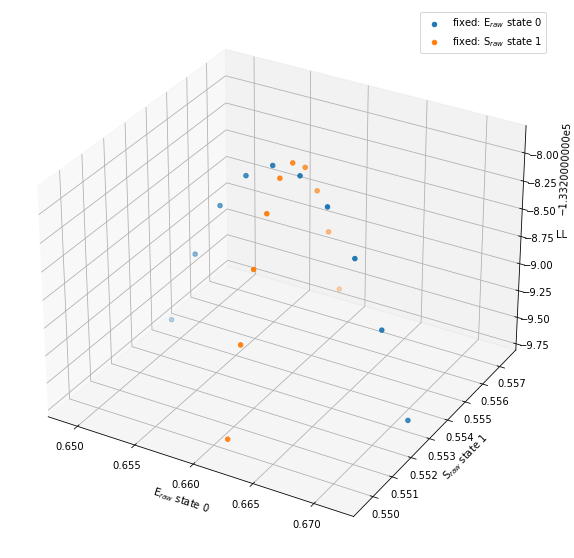

In [55]:
xE = bdata.models[2].loglik_err.E_covar[0].E[:,0] # state 0 E values
yE = bdata.models[2].loglik_err.E_covar[0].S[:,1] # state 1 E values
zE = bdata.models[2].loglik_err.E_covar[0].loglik # loglikelihood, note that there is no state specification

xS = bdata.models[2].loglik_err.S_covar[1].E[:,0] # state 0 E values
yS = bdata.models[2].loglik_err.S_covar[1].S[:,1] # state 1 E values
zS = bdata.models[2].loglik_err.S_covar[1].loglik # loglikelihood, note that there is no state specification

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(xE, yE, zE, label='fixed: E$_{raw}$ state 0')
ax.scatter(xS, yS, zS, label='fixed: S$_{raw}$ state 1')

ax.set_xlabel("E$_{raw}$ state 0")
ax.set_ylabel("S$_{raw}$ state 1")
ax.set_zlabel("LL")
ax.legend()

The key point, is that you have access to all non-lifetime model parameters (not dwell parameters) through identically named elements, and you can see how they correlate with one another and the overall logliklihood.